# MLFinance
Machine learning in finance


## Task 1
1) Приблизить формулу Блэка Шоулза с помощью нейронки
2) Обучающие данные сэмплировать из равномерного распределения
3) Оценить качество модели по таргетам
## Task 2 
1) По полученной аппроксимации посчитать греки
2) Проверить качество греков по таргетам


### Black-Scholes formula

$$
V^{\text{call}} = S\Phi(d_1) - e^{-rT}K\Phi(d_2), \quad
V^{\text{put}} = e^{-rT} K\Phi(-d_2) -S\Phi(-d_1),
$$
where $\Phi(x)$ is the standard normal cumulative distribution function, and
$$
d_1 = \frac{1}{\sigma\sqrt{(T - t)}} \biggl(\ln\frac{S}{K} 
  + \biggl(r+\frac{\sigma^2}{2}\biggr) (T - t)\biggr), \qquad 
d_2 = \frac{1}{\sigma\sqrt{(T - t)}} \biggl(\ln\frac{S}{K} 
  + \biggl(r-\frac{\sigma^2}{2}\biggr) (T - t)\biggr).
$$
**Note**: the option price is monotone as a function of $\sigma$.
We can invert the Black-Scholes formula to obtain
$$
\sigma^{IV} = V^{-1}(p),
$$
where $p$ is the observed market price.

### Greeks

Delta 
$$\Delta^{call} = \displaystyle \frac{\partial V^{call}}{\partial S} = \Phi(d_1)$$
$$\Delta^{put} = \displaystyle \frac{\partial V^{put}}{\partial S} = -\Phi(-d_1) = \Phi(d_1) - 1$$

Gamma
$$
\Gamma = \displaystyle\frac{\partial^{2} V}{\partial S^{2}} = \frac{\Phi'(d_1)}{S\sigma\sqrt{T - t}}
$$

Vega
$$
\mathcal{V} = \displaystyle \frac{\partial V}{\partial \sigma} = S \Phi'(d_1) \sqrt{T-t}
$$

Theta
$$
\theta^{call} = \displaystyle \frac{\partial V^{call}}{\partial t} = 
\frac{S \Phi'(d_1) \sigma}{2 \sqrt{T - t}} - rKe^{-r(T - t)}\Phi(d_2)
$$
$$
\theta^{put} = \displaystyle \frac{\partial V^{put}}{\partial t} =
\frac{S \Phi'(d_1) \sigma}{2 \sqrt{T - t}} + rKe^{-r(T - t)}\Phi(-d_2)
$$

Rho
$$
\rho^{call} = \displaystyle \frac{\partial V^{call}}{\partial r} = 
K(T - t)e^{-r(T - t)}\Phi( d_2)
$$
$$
\rho^{put} = \displaystyle \frac{\partial V^{put}}{\partial r} =
-K(T - t)e^{-r(T - t)}\Phi(-d_2)
$$

* Возьмем часть кода (реализация греков ) с семинаров Веги по стох волатильности

In [21]:
from typing import Union, Optional, Callable
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt
from scipy import stats
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

from ipywidgets import interact
from ipywidgets import widgets
from tqdm.auto import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
from Market.market import CallStockOption,PutStockOption,MarketState,BSParams
from Market.market import price,delta,gamma,theta,vega,rho

## Visualization prices (from vega seminar)

In [5]:
strikes = np.linspace(50, 150, 5)
times = np.linspace(0, 2, 4)
calls = CallStockOption(strike_price=strikes,
                        expiration_time=times[:, None])
puts = PutStockOption(strike_price=strikes,
                      expiration_time=times[:, None])
ms = MarketState(stock_price=100, interest_rate=0.1)

params = BSParams(volatility=0.2)

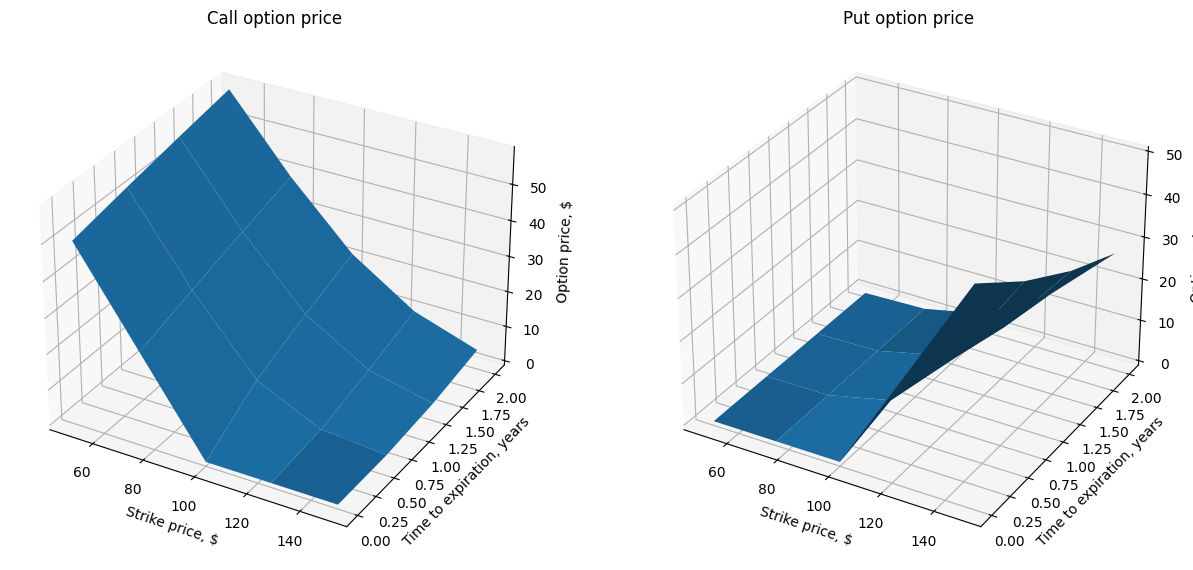

In [6]:
x, y = np.meshgrid(strikes, times)
call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')

plt.show()

## Model: MLP

* Попробуем предсказывать price для пут опциона

* $V(S, K, T, t, r, \sigma)$

* $T$: option.expiration_time
* $K$: option.strike_price
* $\sigma$: params.volatility
* $t$: ms.time
* $r$: ms.interest_rate
* $S$: ms.stock_price

In [14]:
class OptionDataset(Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples
        self.data = self.generate_data()

    def generate_data(self):
        data = []
        for _ in tqdm(range(self.num_samples)):
            T = np.random.uniform(0.1, 2.0)  # expiration_time
            K = np.random.uniform(50, 150)  # strike_price
            sigma = np.random.uniform(0.1, 0.5)  # volatility
            t = np.random.uniform(0, T)  # current time
            r = np.random.uniform(0.01, 0.05)  # interest_rate
            S = np.random.uniform(50, 150)  # stock_price
            
            puts = PutStockOption(strike_price=K, expiration_time=T)
            ms = MarketState(stock_price=S, interest_rate=r)
            params = BSParams(volatility=sigma)
            option_price = price(puts, ms, params)
            data.append([S, K, T, t, r, sigma, option_price])
        return data

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        sample = self.data[idx]
        features = torch.tensor(sample[:-1], dtype=torch.float32)
        target = torch.tensor(sample[-1], dtype=torch.float32)
        return features, target

In [15]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [16]:
batch_size = 32
num_samples = 10000
option_dataset = OptionDataset(num_samples)
dataloader = DataLoader(option_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:08<00:00, 1195.93it/s]


In [17]:
input_size = 6
hidden_size = 128
output_size = 1
model = MLP(input_size, hidden_size, output_size)

In [18]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    for i, (features, target) in enumerate(dataloader):
        outputs = model(features)
        loss = criterion(outputs, target.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

print("Training complete")

Epoch [1/50], Step [100/313], Loss: 22.2180
Epoch [1/50], Step [200/313], Loss: 14.8525
Epoch [1/50], Step [300/313], Loss: 30.7541
Epoch [2/50], Step [100/313], Loss: 16.1305
Epoch [2/50], Step [200/313], Loss: 8.3590
Epoch [2/50], Step [300/313], Loss: 9.1527
Epoch [3/50], Step [100/313], Loss: 12.6157
Epoch [3/50], Step [200/313], Loss: 12.4855
Epoch [3/50], Step [300/313], Loss: 6.6680
Epoch [4/50], Step [100/313], Loss: 11.2414
Epoch [4/50], Step [200/313], Loss: 7.8860
Epoch [4/50], Step [300/313], Loss: 13.6478
Epoch [5/50], Step [100/313], Loss: 9.9060
Epoch [5/50], Step [200/313], Loss: 8.9778
Epoch [5/50], Step [300/313], Loss: 14.5814
Epoch [6/50], Step [100/313], Loss: 7.6283
Epoch [6/50], Step [200/313], Loss: 11.7964
Epoch [6/50], Step [300/313], Loss: 9.6069
Epoch [7/50], Step [100/313], Loss: 10.2957
Epoch [7/50], Step [200/313], Loss: 12.4729
Epoch [7/50], Step [300/313], Loss: 16.8111
Epoch [8/50], Step [100/313], Loss: 16.6525
Epoch [8/50], Step [200/313], Loss: 15.6

## Visualization + comparison

In [49]:
strikes = np.linspace(50, 150, 5)
times = np.linspace(0, 2, 4)
puts = PutStockOption(strike_price=strikes,
                      expiration_time=times[:, None])
ms = MarketState(stock_price=100, interest_rate=0.1)
params = BSParams(volatility=0.2)

In [50]:
put_prices = price(puts, ms, params)
put_prices.shape

(4, 5)

In [51]:
params_grid = np.array([[[ms.stock_price, strike, T, ms.time, ms.interest_rate, params.volatility] for strike in strikes] for T in times ] )
params_tensor = torch.tensor(params_grid, dtype=torch.float32)
params_tensor.shape

torch.Size([4, 5, 6])

In [52]:
model.eval()
with torch.no_grad():
    model_predictions = model(params_tensor).numpy()
model_predictions.shape

(4, 5, 1)

In [53]:
model_put_prices = model_predictions.squeeze()
model_put_prices.shape

(4, 5)

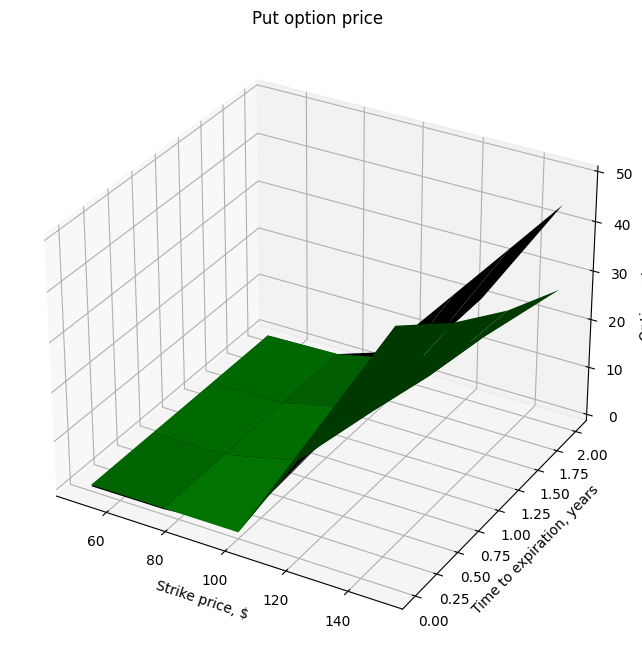

In [54]:
x, y = np.meshgrid(strikes, times)
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(x, y, put_prices, color = 'green')#, label = 'Put prices')
ax1.plot_surface(x, y, model_put_prices, color = 'black')#, label = 'Put predictions (MLP)')
ax1.set_title('Put option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

plt.show()